# scikit-learnの基礎

この項では、scikit-learnを用いた機械学習の基礎と、得られた結果の評価方法について学ぶ。

scikit-learnは

`fit`という関数に対して、説明変数$X$と目的変数$y$を与えることで簡単に識別や回帰のモデルを作ることができる。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import ConfusionMatrixDisplay

## 識別問題 (classification)

In [2]:
# 以下のコードはデータのダウンロードを伴うため、少々時間がかかる
X, y = datasets.fetch_openml("mnist_784", return_X_y=True, data_home="./mnist", parser="auto")
X = np.asarray(X / 255.0, dtype="float32")
y = np.asarray(y, dtype="uint8")

MNISTのデータは訓練とテストのそれぞれに60000個, 10000個のデータが用意されているので、`train_test_split`を用いてデータを分割しておく。

In [3]:
from sklearn import model_selection

X_train, X_test = model_selection.train_test_split(
    X, train_size=60000, test_size=10000, shuffle=False
)
y_train, y_test = model_selection.train_test_split(
    y, train_size=60000, test_size=10000, shuffle=False
)

今回は計算時間の短縮のために、先頭10000個のデータだけを使って、以下の実験を行う。

In [4]:
n_samples = 10000
X_train, y_train = X_train[:n_samples], y_train[:n_samples]

### 最近傍探索による識別

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# 識別モデルの構築
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)

# 訓練時の識別精度の確認
y_pred = neigh.predict(X_train)
acc_train = 100.0 * np.sum(y_pred == y_train) / len(y_train)
print("knn: acc(train)={:.2f}%".format(acc_train))

knn: acc(train)=94.59%


In [6]:
y_pred = neigh.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("knn: acc(test)={:.2f}%".format(acc_test))

knn: acc(test)=93.48%


このような多クラスの識別問題を扱う場合、識別器の性質を評価するために混同行列(confusion matrix)を用いる。混同行列とは、識別器が間違いの識別を行ったときに、どのクラスとどのクラスを誤識別しているのかを表す。

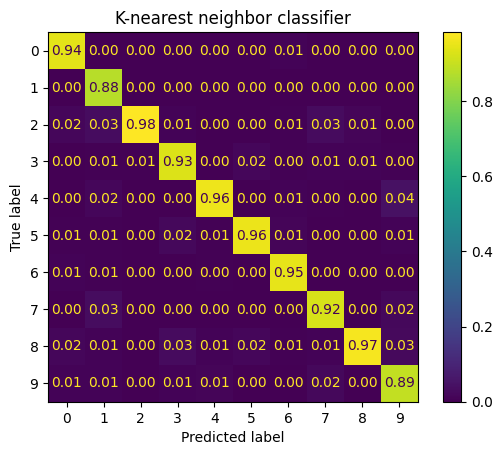

In [7]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="pred", values_format=".2f", ax=plt.gca()
)
plt.title("K-nearest neighbor classifier")
plt.show()

In [8]:
from sklearn.ensemble import AdaBoostClassifier

# 訓練モデルの構築
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

# 訓練時の識別精度の確認
y_pred = ada.predict(X_train)
acc_train = 100.0 * np.sum(y_pred == y_train) / len(y_train)
print("AdaBoost: acc(train)={:.2f}%".format(acc_train))

AdaBoost: acc(train)=67.29%


In [9]:
y_pred = ada.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("AdaBoost: acc(test)={:.2f}%".format(acc_test))

AdaBoost: acc(test)=65.30%


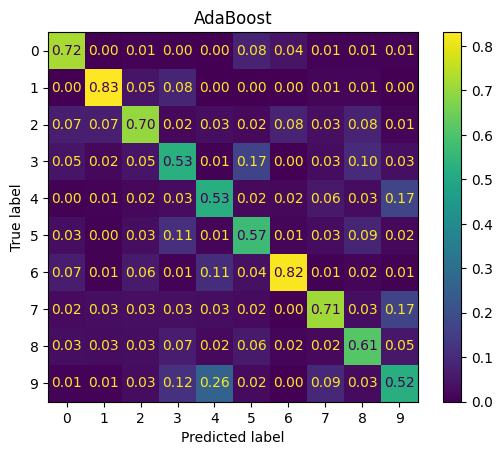

In [10]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="pred", values_format=".2f", ax=plt.gca()
)
plt.title("AdaBoost")
plt.show()

In [11]:
from sklearn.svm import SVC

lin_svm = SVC(kernel="linear", C=1.0, max_iter=100)
lin_svm.fit(X_train, y_train)

y_pred = lin_svm.predict(X_train)
acc_train = 100.0 * np.sum(y_pred == y_train) / len(y_train)
print("Linear SVM: acc(train)={:.2f}%".format(acc_train))

C:\Users\tatsuya\AppData\Local\pypoetry\Cache\virtualenvs\sds-adv-ml-NOwn6uOF-py3.10\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear SVM: acc(train)=92.67%


In [12]:
y_pred = lin_svm.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Linear SVM: acc(test)={:.2f}%".format(acc_test))

Linear SVM: acc(test)=88.30%


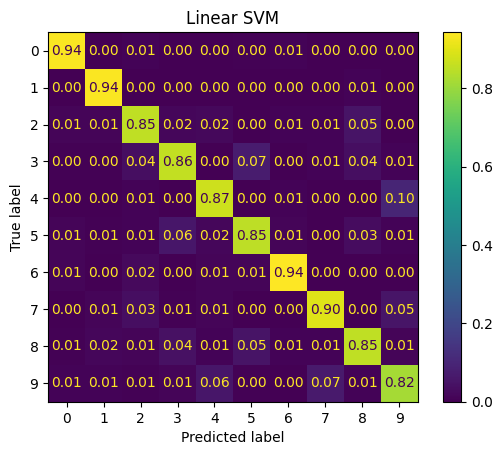

In [13]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="pred", values_format=".2f", ax=plt.gca()
)
plt.title("Linear SVM")
plt.show()

In [14]:
rbf_svm = SVC(kernel="rbf", gamma=2.0, C=0.025, max_iter=200)
rbf_svm.fit(X_train, y_train)

y_pred = rbf_svm.predict(X_train)
acc_train = 100.0 * np.sum(y_pred == y_train) / len(y_train)
print("RBF SVM: acc(train)={:.2f}%".format(acc_train))

C:\Users\tatsuya\AppData\Local\pypoetry\Cache\virtualenvs\sds-adv-ml-NOwn6uOF-py3.10\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF SVM: acc(train)=93.57%


In [15]:
y_pred = rbf_svm.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("RBF SVM: acc(test)={:.2f}%".format(acc_test))

RBF SVM: acc(test)=90.75%


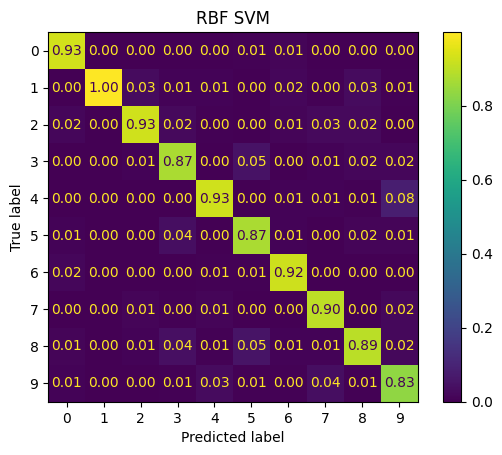

In [16]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="pred", values_format=".2f", ax=plt.gca()
)
plt.title("RBF SVM")
plt.show()

## 回帰問題 (Regression)

## 二値識別問題

https://adfi.jp/ja/download/